In [1]:
import os
import datetime

import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt

import datacube
dc = datacube.Datacube()


In [2]:
fire_events = pd.read_csv('fire_events.csv', index_col=0)
fire_events

,lon_min,lon_max,lat_min,lat_max,time_min,time_max,fire_date,sensor
EventName,,,,,,,,
BlackSaturday,145.0000,145.9000,-37.2000,-37.7000,2000-01,2009-12,2009-02-07,ls5
Tas2016_Central_Plateau,146.0852,146.3702,-41.5985,-41.7314,2013-01,2018-01,2016-02-08,ls8
Tas2016_Sumac_Forest,144.6893,145.1582,-41.0711,-41.3711,2013-01,2018-01,2016-02-08,ls8
MtCanobolas,148.9419,149.0322,-33.3014,-33.3882,2013-01,2018-12,2018-02-10,ls8
RoyalNationalPark,150.8749,151.1500,-34.0713,-34.2570,2013-01,2018-12,2018-01-20,ls8


In [4]:
def _get_Reflectance():
    """This calls the dc.load function on the NBAR reflectance product.
    This uses the sensor specified in the 'fire_events.csv' file."""

    start_time = datetime.datetime.now()

    reflectance = dc.load( product=  sensor + '_nbar_albers', 
               x=lon_extent, 
               y=lat_extent,
               time = time_bounds,
               resolution = (-100,100)
               , dask_chunks = {'time': 5}
                     )

    reflectance = reflectance.where((reflectance != -999))

    end_time = datetime.datetime.now()
    print ("reflectance loading took: ", (end_time - start_time))
    print ("reflectance: ", (reflectance).nbytes / 10**9 , "GB")

    return (reflectance)


def _get_Pixel_Quality():
    """This calls the dc.load function on the pixel quality product.
    This uses the sensor specified in the 'fire_events.csv' file."""

    start_time = datetime.datetime.now()
    pq = dc.load( product=  sensor + '_pq_albers', 
           x=lon_extent, 
           y=lat_extent,
           time = time_bounds,
           resolution = (-100,100)
           , dask_chunks = {'time': 5}
                     )
    end_time = datetime.datetime.now()

    # This next chunk creates a cloud_mask using the datacube masking methods
    from datacube.storage import masking
    cloud_mask = masking.make_mask(pq, 
        cloud_acca='no_cloud', cloud_fmask='no_cloud',
        cloud_shadow_acca = 'no_cloud_shadow', cloud_shadow_fmask = 'no_cloud_shadow',
        contiguous=True #, land_sea = 'land'
        ).pixelquality
    
    print ("cloud mask loading took: ", (end_time - start_time))
    print ("cloud mask: ", (cloud_mask).nbytes / 10**9 , "GB")
    return cloud_mask


def _plot_RGB(xarray_dataset = None):
    rgb = xarray_dataset.drop(['coastal_aerosol','nir','swir1','swir2'])
    rgb = xr.merge([rgb.red,rgb.green,rgb.blue])
    rgb = rgb.to_array(dim='color',name=None)
    
    fake_saturation = 2000
    
    rgb = rgb.transpose(*(rgb.dims[1:]+rgb.dims[:1]))  # make 'color' the last dimension
    rgb = rgb.where((rgb <= fake_saturation).all(dim='color'))  # mask out pixels where any band is 'saturated'
    rgb /= fake_saturation  # scale to [0, 1] range for imshow

    rgb.plot.imshow(
        x=xarray_dataset.crs.dimensions[1], y=xarray_dataset.crs.dimensions[0],
                    col='time', col_wrap=5, add_colorbar=False)
    
def _get_unique_dates(times = None):
    times = pd.to_datetime(times)
    
    #times = times.date
    for step in range(0,len(times)-1):
        try:
            if times.date[step] == times.date[step+1]:
                times = np.delete(times,step)
        except IndexError:
            pass
    
    times = times.values
    times = pd.to_datetime(times).date.astype(np.datetime64)
        
    return(times)

In [12]:
event_name = 'RoyalNationalPark'     #ENTER HERE
name = (fire_events[fire_events.index==event_name].index.values[0] ) 
lat_extent = ( fire_events[fire_events.index==event_name].lat_min.values[0] ,
                   fire_events[fire_events.index==event_name].lat_max.values[0] )
lon_extent = ( fire_events[fire_events.index==event_name].lon_min.values[0] ,
                   fire_events[fire_events.index==event_name].lon_max.values[0] )
time_bounds = ( fire_events[fire_events.index==event_name].time_min.values[0] ,
                   fire_events[fire_events.index==event_name].time_max.values[0] )

sensor = fire_events[fire_events.index==event_name].sensor.values[0]

#time_bounds = (np.datetime64('2017-07') , np.datetime64('2018-12'))
#sensor = 'ls8'


In [13]:
A = _get_Reflectance()
A = A.resample(freq='D', dim = 'time', how='mean', keep_attrs=True).sel(time= _get_unique_dates(A.time.values) )

B = _get_Pixel_Quality()
B = B.resample(freq='D', dim = 'time', how='mean', keep_attrs=True).sel(time= _get_unique_dates(B.time.values) )


if sensor == 'ls5':
    variables = ['blue','green','red','nir','swir1','swir2']
else:
    variables = ['coastal_aerosol','blue','green','red','nir','swir1','swir2']
    
for i in variables:
    A[i].attrs['units'] = '1'
A.time.attrs['units'] = 'seconds since 1970-01-01 00:00'

reflectance loading took:  0:00:00.626772
reflectance:  1.239505072 GB


/g/data/v10/public/modules/agdc-py3-env/20171214/envs/agdc/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: 
.resample() has been modified to defer calculations. Instead of passing 'dim' and 'how="mean", instead consider using .resample(time="D").mean() 
  
/g/data/v10/public/modules/agdc-py3-env/20171214/envs/agdc/lib/python3.6/site-packages/xarray/core/common.py:619: FutureWarning: pd.TimeGrouper is deprecated and will be removed; Please use pd.Grouper(freq=...)
  label=label, base=base)


cloud mask loading took:  0:00:06.424670
cloud mask:  0.022545054 GB


/g/data/v10/public/modules/agdc-py3-env/20171214/envs/agdc/lib/python3.6/site-packages/ipykernel_launcher.py:5: DeprecationWarning: 
.resample() has been modified to defer calculations. Instead of passing 'dim' and 'how="mean", instead consider using .resample(time="D").mean() 
  """
/g/data/v10/public/modules/agdc-py3-env/20171214/envs/agdc/lib/python3.6/site-packages/xarray/core/common.py:619: FutureWarning: pd.TimeGrouper is deprecated and will be removed; Please use pd.Grouper(freq=...)
  label=label, base=base)


In [7]:
datacube.storage.storage.write_dataset_to_netcdf(A, ('%s_NBAR - %s.nc') % (name, sensor))

/g/data/v10/public/modules/agdc-py3-env/20171214/envs/agdc/lib/python3.6/site-packages/dask/array/numpy_compat.py:46: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


In [8]:
C = A.where(
    B.isel(time = B.sum(dim=('x','y'))/(len(B.x)*len(B.y)) > 0.1) # Cloud_masked, with frames less than 10% coverage dropped
       )

datacube.storage.storage.write_dataset_to_netcdf(C, ('%s_NBAR_cloudmasked - %s.nc') % (name, sensor))
del(C)

/g/data/v10/public/modules/agdc-py3-env/20171214/envs/agdc/lib/python3.6/site-packages/dask/array/numpy_compat.py:46: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


In [26]:
A['NBR'] = (A.nir - A.swir1)/(A.nir+A.swir1)

/g/data/v10/public/modules/agdc-py3-env/20171214/envs/agdc/lib/python3.6/site-packages/dask/array/numpy_compat.py:46: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


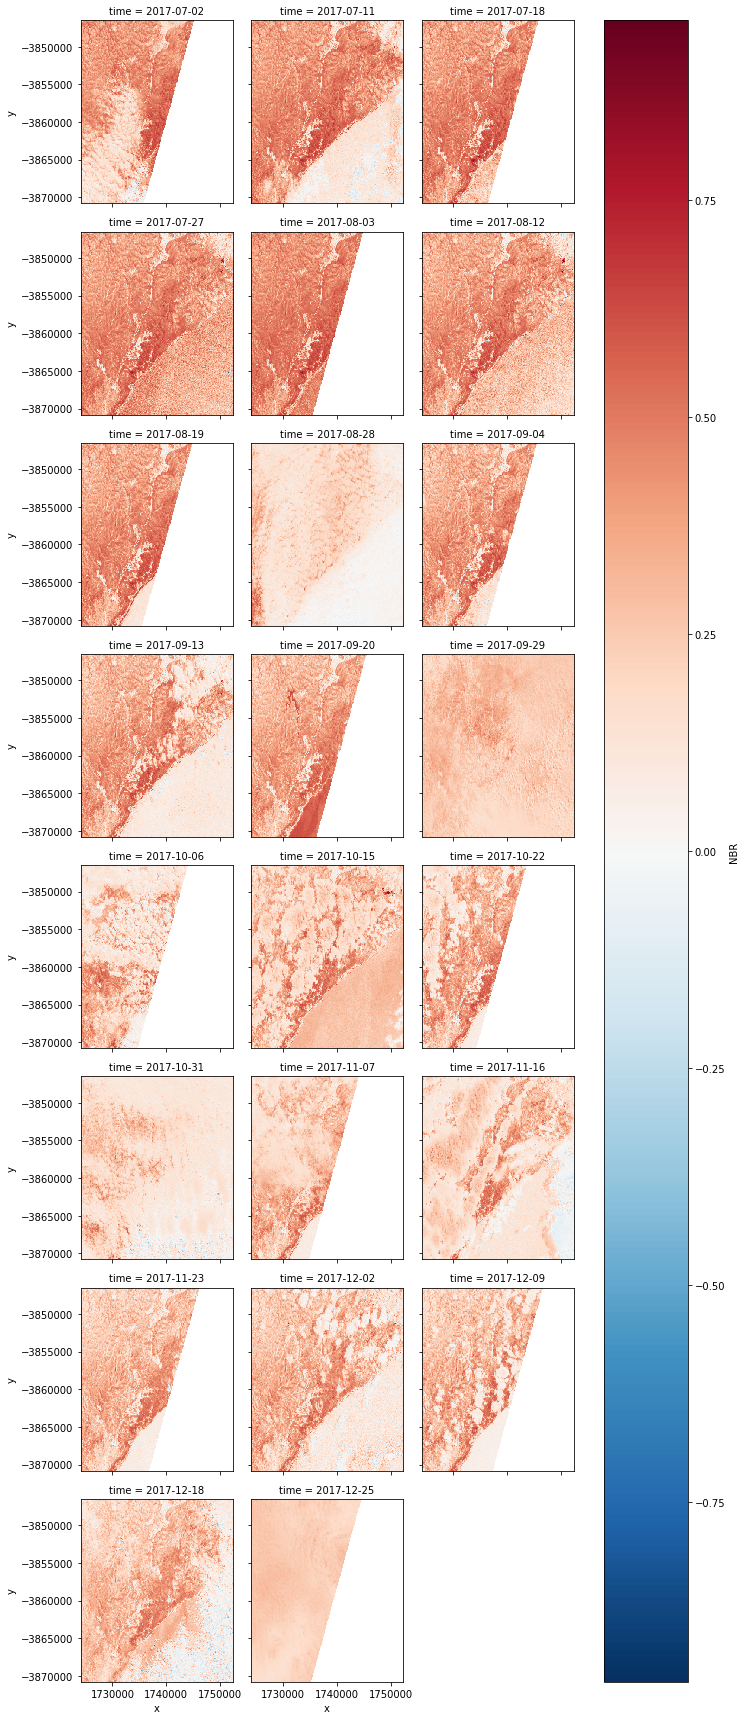

In [30]:
A.sel(time=slice('2017-07-01','2017-12-31')).NBR.plot.imshow(col='time',col_wrap=3)